# World Bank presentation - Graphs

In [50]:
from IPython.display import set_matplotlib_formats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure as figure

import matplotlib
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

%matplotlib inline
sns.set_theme(style="whitegrid", palette="pastel")
set_matplotlib_formats('svg')

CONTROL = "#F95700FF"#"#ffc387"
TREATED = "#00A4CCFF"#"#9ed9c3"
palette_anc = [CONTROL, TREATED]
order=["control","treated"]

SOURCE_WT_FORMS = "Source: intervention forms"
SOURCE_REG = "Source: Facilities' registry book (Gov. of Mozambique)"

In [51]:
def size_1st(anc):
    len_c = len(anc.query("consultation_reason == 1 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 1 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

def size_followup(anc):
    len_c = len(anc.query("consultation_reason == 2 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 2 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

In [52]:
lse = "/Users/vincenzoalfano/LSE - Health/anc_hiv_scheduling"
img = f"{lse}/graphs"
cleaned_path = f"{lse}/data/cleaned_data"

In [53]:
treat_control = f"{lse}/data/aux/treatment_hdd.dta"
tc_df = pd.read_stata(treat_control)
tc_df = tc_df[["facility_cod", "treatment"]]
tc_df["treatment_status"] = "treated"
tc_df.loc[tc_df["treatment"] == 0, "treatment_status"] = "control"

anc = pd.read_csv(f"{cleaned_path}/anc_cpn_endline_v20230704.csv")

In [54]:
# registry book
#path = "/Users/rafaelfrade/arquivos/desenv/lse/anc_rct/surveys/data_csv/Endline"
path = cleaned_path
reg_book = pd.read_csv(f"{path}/anc_registry_book.csv")
reg_book = reg_book[reg_book["facility_cod"].str.len()<=2]
reg_book = reg_book[reg_book["anc_total"].str.len()<=2]
reg_book["anc_total"] = reg_book["anc_total"].astype(int)
reg_book = reg_book[reg_book["anc_total"] <= 40]

reg_book = reg_book[reg_book["gestational_age_1st"].str.len()<=2]
reg_book["gestational_age_1st"] = reg_book["gestational_age_1st"].astype(int)
reg_book["facility_cod"] = reg_book["facility_cod"].astype(int)
reg_book["gestational_age_1st"] = reg_book["gestational_age_1st"].astype(int)
reg_book = reg_book[reg_book["gestational_age_1st"]<=40]

reg_book.loc[reg_book["facility_name"] == "CS Urbano" ,"facility_cod"] = 50
reg_book.loc[reg_book["facility_name"] == "CS Unidade 7" ,"facility_cod"] = 66
reg_book.loc[reg_book["facility_name"] == "CS Porto" ,"facility_cod"] = 4

reg_book = reg_book.merge(tc_df, left_on="facility_cod", right_on="facility_cod",
                          how="inner")

#### common functions

In [55]:
import numpy as np
def time_to_time_float(time):
    """ transforms 730 into 7.5 """
    if not time:
        return np.nan
    time = str(time)
    size = len(time)
    hour = float(time[0:(size-2)])
    minute = float(time[(size-2):size])
    return hour + round(minute/60, 2)


assert time_to_time_float(730) == 7.5
assert time_to_time_float(1000) == 10
assert time_to_time_float(1020) == 10.33

#### avg waiting_time

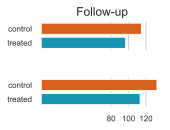

In [56]:
#plt.figure(figsize=(3, 2))
i = 0
g = sns.catplot(kind="bar", x="waiting_time", y="treatment_status",
            data=anc.query("consultation_reason.isin([1,2])"),
            palette=palette_anc, 
            hue_order=order, orient = 'h',
            col="reason", errorbar=None,
            col_wrap=1,height=1.1, aspect=2.6)
sns.despine(left=True, bottom=True)
#sns.move_legend(g, "lower center", ncol=2, title="")
g.set_titles(template="{col_name}")
plt.xticks([80, 100,  120], fontsize=8)
g.set(xlabel="", ylabel="")
plt.yticks(fontsize=8)
plt.subplots_adjust(hspace=0.4)

#g.set(ylim=[30, None])

for ax,title in zip(g.axes.flatten(),["A", "B"]):
    ax.tick_params(axis='both', labelsize=8)

plt.title("")
plt.subplots_adjust(hspace = 1)
plt.show()

#g._legend.set(title="")

In [57]:
order_=None
normalize=True
figure=False

title = ""
re = (reg_book.groupby("treatment_status")["anc_total"]
                         .value_counts(normalize=normalize)
                         .rename('percent')
                         .reset_index()
                     .rename(columns={"index":"reason"})
)

<AxesSubplot: title={'center': 'Visits by day of the week for 1st visits consultations'}>

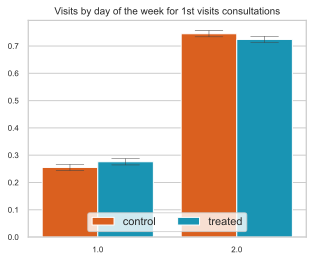

In [58]:
import scipy.stats as st

def get_confidence_interval(n, mean, sem):
    return st.t.interval(alpha=0.95, df=n, loc=mean, scale=sem)

def add_error_bar(means, se):
    for i, mean in enumerate(means):
        plt.errorbar(str(i), 
             mean,
             yerr=se[i], 
             color='black',
             ecolor='black', elinewidth=.5, 
             capsize=2, markeredgewidth=.5)

def get_value_counts(df, var, normalize=True):
    countplot_df = (df.groupby("treatment_status")[var]
                         .value_counts(normalize=normalize)
                         .rename('percent')
                         .reset_index()
                     .rename(columns={"index":"reason"})
                   .sort_values([var,"treatment_status"]
                                ,ascending=True))
    countplot_df = countplot_df.query("percent >= 0.01")
    return countplot_df

n = 0
def plot_cathegorical(df, var, title, y_size=5, order_=None,
                      normalize=True, x_size=5, figure=True,
                      error=False):
    """
        plots a normalized count plot of the variable selected
    """
    global n
    if figure:
        plt.figure(figsize=(x_size, y_size), dpi=80)

    countplot_df = get_value_counts(df, var, normalize=normalize)
    copy = countplot_df.copy()
    countplot_df = pd.concat([countplot_df,copy], axis=0)
    
    if error:
        value_counts_df = get_value_counts(df, var, normalize=False)

        #sem = (df.groupby("treatment_status")[var]
        #             .value_counts(normalize=normalize).sem())
        
        i = 0
        n = len(df)/2
        def get_errors(df):
            global n
            mean = df.mean()
            #n = value_counts_df.iloc[i]["percent"]
            ##ci = get_confidence_interval(n, mean, sem)
            p = mean
            se_95 = 1.96*np.sqrt(p*(1-p)/n)
            return (mean - se_95, mean + se_95)

        countplot_df["test"] = 1
        g = sns.barplot(x=var, y="percent",  hue="treatment_status", 
                     data=countplot_df, palette=palette_anc,
                     hue_order=order, errorbar=get_errors,
                     errwidth=0.5, capsize=0.2)
    else:
        g = sns.barplot(x=var, y="percent",  hue="treatment_status", 
             data=countplot_df, palette=palette_anc,
             hue_order=order)

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(title ,fontsize=10)
    sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)
    #plt.show()
    return g

    
title = "Visits by day of the week for 1st visits consultations"
plot_cathegorical(anc.query("consultation_reason.isin([1,2])"),
                  "consultation_reason", title, y_size=4,
                     normalize=True, error=True)

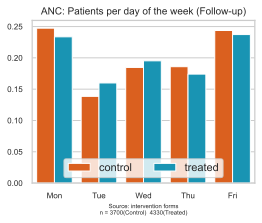

In [59]:
dow = ["Mon", "Tue", "Wed", "Thu", "Fri"]

def rename_dow(df, i):
    df.loc[anc["day_of_week"] == i, "dow"] =  dow[i-1]

[ rename_dow(anc, i)  for i in range(1, 6) ]

by_dow = (anc.query("consultation_reason == 2")
          .groupby(["treatment_status", "dow"])
    .agg({"us_id":"size", "day_of_week":"first"})
    .rename(columns={"us_id":"count"})
    .reset_index().sort_values("day_of_week"))
by_dow["weighted"] = by_dow["count"].div([3,3,3,3,2,2,2,2,2,2])
by_dow["percent"] = (by_dow['weighted'] / 
          by_dow.groupby('treatment_status')['weighted']
              .transform('sum'))

plt.figure(figsize=(4, 3), dpi=80)
g = sns.barplot(x="dow", y="percent",  hue="treatment_status", 
            data=by_dow, palette=palette_anc,
             hue_order=order)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
SIZE_FOLLOWUP = "n = 3700(Control)  4330(Treated)"
plt.xlabel(SOURCE_WT_FORMS + "\n"+ SIZE_FOLLOWUP , fontsize=6)
plt.ylabel("")

plt.title("ANC: Patients per day of the week (Follow-up)",
          fontsize=10)
sns.move_legend(g, "lower center", ncol=2, title="",frameon=True)
#plt.savefig(f"{img}/opening_hours.jpeg", bbox_inches='tight',dpi=300)

plt.show()


#### hiv

In [60]:
#path_hiv = "/Users/rafaelfrade/arquivos/desenv/lse/ocr_hiv"
#hiv = pd.read_csv(f"{path_hiv}/hiv_endline_cleaned.csv")#.query("flag == 0")
hiv = pd.read_stata(f"{cleaned_path}/hiv_endline.dta")#.query("flag == 0")

hiv["treatment_status"] = "treated"
hiv.loc[hiv["treatment"] == 0, "treatment_status"] = "control"

hiv["pickup_time"] = hiv["consultation_time"]

hiv["id"] = (hiv["facility_cod"].astype("str") + "_" + hiv["day"].astype("str") + "_" + 
            hiv["page"].astype("str") + "_" +  hiv["line"].astype("str"))

#### hiv: mean

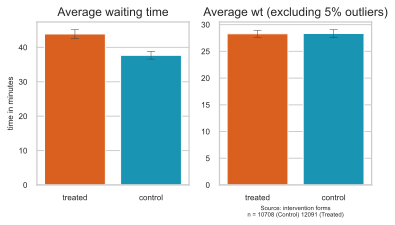

In [61]:
title = "Average waiting time"

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
sns.barplot(hiv, x="treatment_status", y="waiting_time",
            palette=palette_anc, errwidth=0.5, capsize=0.1,
            hue_order=order, errorbar=("se", 1.96))
plt.title(title)
plt.xlabel("")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("time in minutes", fontsize=8)

plt.subplot(1, 2, 2)
title = "Average wt (excluding 5% outliers)"

sns.barplot(hiv.query("waiting_time <= 180"), 
            x="treatment_status", y="waiting_time",
            palette=palette_anc, errwidth=0.5, capsize=0.1,
            hue_order=order, errorbar=("se", 1.96))
plt.title(title)

SIZE_HIV = "n = 10708 (Control) 12091 (Treated)"
plt.xlabel(SOURCE_WT_FORMS + "\n"+ SIZE_HIV , fontsize=6)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("", fontsize=8)

plt.show()

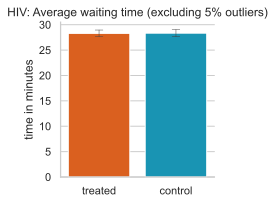

In [62]:
title = "HIV: Average waiting time (excluding 5% outliers)"

sns.catplot(hiv.query("waiting_time <= 180"), 
            x="treatment_status", y="waiting_time", kind="bar",
            palette=palette_anc, errwidth=0.5, capsize=0.1,
            hue_order=order, errorbar=("se", 1.96),
            aspect=1, height=3)
plt.title(title)
plt.xlabel("")
plt.ylabel("time in minutes")
plt.show()

#### HIV: count

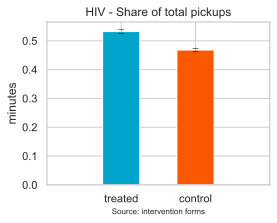

In [63]:
mean_c = hiv.query("treatment == 0")["id"].count()/hiv["id"].count()
mean_t = hiv.query("treatment == 1")["id"].count()/hiv["id"].count()

sem_c = hiv["treatment"].sem()*1.96
sem_t = hiv["treatment"].sem()*1.96

f, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.bar(1, mean_t,
             linestyle="-", color=TREATED, label="treatment", width=0.5)
ax.errorbar(1,
             mean_t,
             yerr=sem_t, 
             color='black',
             ecolor='black', elinewidth=.2, capsize=3,markeredgewidth=0.5)

ax.bar(2, mean_c,
             linestyle="-", color=CONTROL, label="control", width=0.5)
ax.errorbar(2,
             mean_c,
             yerr=sem_c,
              color='black',
             ecolor='black', elinewidth=.2, capsize=3,markeredgewidth=0.5)

plt.style.use("default")
plt.title(f"HIV - Share of total pickups")
plt.ylabel("minutes")
plt.xticks([1, 2], ["treated","control"])
plt.style.use("seaborn-whitegrid")
#ax.set_ylim([50, 120])
ax.set_xlim([0, 3])
plt.xlabel(SOURCE_WT_FORMS, size=8)
#ax.legend()
plt.show()

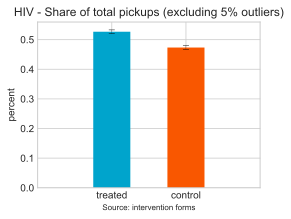

In [64]:
hiv_no_outliers = hiv.query("waiting_time < 180")

mean_c = hiv_no_outliers.query("treatment == 0")["id"].count()/hiv_no_outliers["id"].count()
mean_t = hiv_no_outliers.query("treatment == 1")["id"].count()/hiv_no_outliers["id"].count()

sem_c = hiv["treatment"].sem()*1.96
sem_t = hiv["treatment"].sem()*1.96

f, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.bar(1, mean_t,
             linestyle="-", color=TREATED, label="treatment", width=0.5)
ax.errorbar(1,
             mean_t,
             yerr=sem_t, 
             color='black',
             ecolor='black', elinewidth=.2, capsize=3,markeredgewidth=0.5)

ax.bar(2, mean_c,
             linestyle="-", color=CONTROL, label="control", width=0.5)
ax.errorbar(2,
             mean_c,
             yerr=sem_c,
              color='black',
             ecolor='black', elinewidth=.2, capsize=3,markeredgewidth=0.5)

plt.style.use("default")
plt.title(f"HIV - Share of total pickups (excluding 5% outliers)")
plt.ylabel("percent")
plt.xticks([1, 2], ["treated","control"])
plt.style.use("seaborn-whitegrid")
#ax.set_ylim([50, 120])
ax.set_xlim([0, 3])
#ax.legend()
plt.xlabel(SOURCE_WT_FORMS, size=8)
plt.show()

#### hiv: arrival time

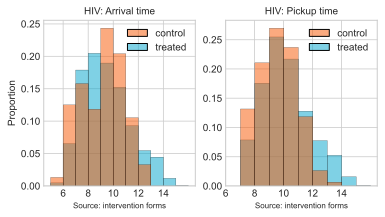

In [65]:
hiv_clean = hiv.query("flag == 0")

hiv_clean["arrival"] = hiv_clean["arrival_time"].div(100)


plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)

g = sns.histplot(x="arrival", 
             data=hiv_clean, binwidth=1,
             hue="treatment_status", stat='proportion',
             common_norm=False, palette=palette_anc,
             hue_order=order)
plt.title("HIV: Arrival time", size=10)
plt.xlabel("Source: Waiting time forms")
plt.xlabel(SOURCE_WT_FORMS, size=8)
plt.xticks(range(6,16,2))
plt.setp(g.patches, linewidth=0.2)
sns.move_legend(g, "upper right", ncol=1, title="")

hiv_clean = hiv.query("flag == 0")

hiv_clean["pickup"] = hiv_clean["consultation_time"].div(100)
plt.subplot(1, 2, 2)
g = sns.histplot(x="pickup", 
             data=hiv_clean, binwidth=1,
             hue="treatment_status", stat='proportion',
             common_norm=False, palette=palette_anc,
             hue_order=order)
plt.title("HIV: Pickup time", size=10)
plt.ylabel("")
plt.xlabel(SOURCE_WT_FORMS, size=8)
sns.move_legend(g, "upper right", ncol=1, title="")
plt.xticks(range(6,16,2))
plt.setp(g.patches, linewidth=0.2)


plt.show()


#### HIV: opening times

In [66]:
from datetime import datetime
def time_diff(final_time, initial_time):
    try:
        final = str(final_time)
        size_f = len(final)
        str_f = final[0:(size_f-2)] + ":" + final[(size_f-2):size_f]

        inital = str(initial_time)
        size_i = len(inital)
        str_i = inital[0:(size_i-2)] + ":" + inital[(size_i-2):size_i]

        FMT = '%H:%M'
        return ((datetime.strptime(str_f, FMT) - datetime.strptime(str_i, FMT))
                    .total_seconds()/60)
    except:
        return -1

open_h = (hiv_clean.groupby(["facility_cod", "day"])
 .agg({"arrival_time":["min", "max"],
       "facility_cod":"min",
       "day":"min",
       "treatment_status":"min"})
 .reset_index())

open_h["open"] = open_h["arrival_time"]["min"]
open_h["close"] = open_h["arrival_time"]["max"]
open_h["facility_cod"] = open_h["facility_cod"]
open_h["day"] = open_h["day"]

open_h = open_h[["facility_cod", "day", "open", "close", "treatment_status"]]
open_h = open_h.droplevel(1, axis=1)

open_h = open_h.loc[:,~open_h.columns.duplicated()].copy()

list_open = open_h['open'].to_list()
list_close = open_h['close'].to_list()
list_wt = []

for (open_, close) in  zip(list_open, list_close):
    list_wt.append(time_diff(close, open_))

open_h["opening_time"] = list_wt

In [67]:
anc["high_vol"] = (anc["volume_base_total"] > 689).astype(int)

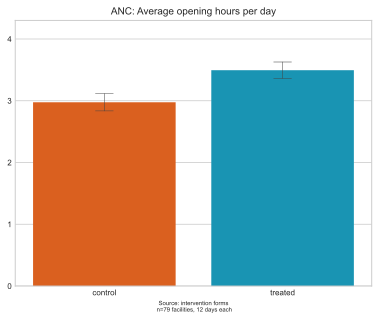

In [68]:
#plt.figure(figsize=(6, 3))
#plt.suptitle("Opening hours")
#plt.subplot(1,2,1)
#open_h["openting_time_hours"] = open_h["opening_time"]/60
#sns.barplot(open_h,
#            x="treatment_status", y="openting_time_hours",
#            palette=palette_anc, errwidth=0.5, capsize=0.1,
#            order=order, errorbar=("se", 1.96))
#
#plt.title("HIV", fontsize=10)
#plt.xlabel(SOURCE_WT_FORMS  + "\n n=80 facilities, 12 days each", size=6)
#plt.ylabel("time in hours", fontsize=8)
#plt.ylim([0,4.3])
#plt.yticks(range(0,5), fontsize=8)
#plt.xticks(fontsize=8)
#
#plt.subplot(1,2,2)
open_h_anc = pd.read_stata(f"{cleaned_path}/opening_time.dta")

title = "ANC: Average opening hours per day"
open_h_anc["treatment_status"] = "treated"
open_h_anc.loc[open_h_anc["treatment"] == 0, "treatment_status"] = "control"

open_h_anc["openting_time_hours"] = open_h_anc["opening_time"]/60
sns.barplot(open_h_anc,
            x="treatment_status", y="openting_time_hours",
            palette=palette_anc, errwidth=0.5, capsize=0.1,
            order=order, errorbar=("se", 1.96))
plt.title(title, fontsize=10)
plt.xlabel(SOURCE_WT_FORMS + "\n n=79 facilities, 12 days each", size=6)
plt.ylabel("")
plt.ylim([0,4.3])
plt.yticks(range(0,5), fontsize=8)
plt.xticks(fontsize=8)

plt.savefig(f"{img}/opening_hours.jpeg", bbox_inches='tight',dpi=300)
plt.show()

## outcomes

ANC: numero de consultas por paciente,
     numero total de pacientes vistas em T vs C.;
     share de pacientes que completa 1/2/3/4 consultas

#### consultations by patient

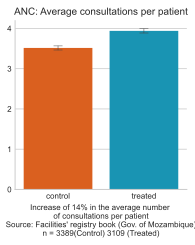

In [69]:
SIZE_REG_BOOK = "n = 3389(Control) 3109 (Treated)"
#sns.barplot(data=reg_book, x="treatment_status", y="anc_total")

def format_graph():
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

title = "ANC: Average consultations per patient"
sns.catplot(data=reg_book,
            x="treatment_status", y="anc_total", kind="bar",
            palette=palette_anc, errwidth=0.5, capsize=0.1,
            order=order, errorbar=("se", 1.96),
            aspect=1, height=3)
plt.title(title, fontsize=10)

xlabel = ("Increase of 14% in the average number \n of consultations per patient \n" +
            SOURCE_REG + "\n" +
           SIZE_REG_BOOK)
plt.xlabel(xlabel, size=8)
plt.ylabel("")
format_graph()

plt.savefig(f"{img}/consultations_per_patient.jpeg", bbox_inches='tight',dpi=300)
plt.show()

#### total number of patients in T/C

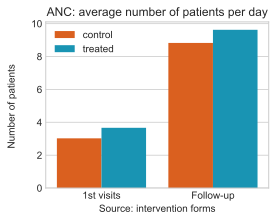

In [70]:
reason_group = (anc.groupby(["treatment_status","reason"])
                .size())

reason_group["control"] = reason_group.loc["control"].div(38).div(12)
reason_group["treated"] = reason_group.loc["treated"].div(39).div(12)
reason_group = reason_group.reset_index().rename(columns={0:"count"})

plt.figure(figsize=(4, 3))
g = sns.barplot(data=reason_group, x="reason", y="count",
            hue="treatment_status", palette=palette_anc,
            hue_order=order)
sns.move_legend(g, "upper left", ncol=1, title="")
plt.xlabel(SOURCE_WT_FORMS)
plt.ylabel("Number of patients \n")
title="ANC: average number of patients per day"
plt.title(title)

#g.errorbar(data=reason_group, x='reason', y='count', yerr='SD',
#           ls='', lw=3, color='black')

plt.show()

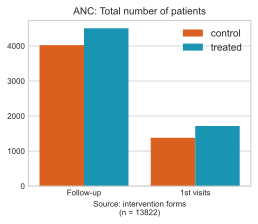

In [71]:

plt.figure(figsize=(4, 3))
g = sns.countplot(data=anc, x="reason", hue="treatment_status",
             palette=palette_anc, hue_order=order)
title="ANC: Total number of patients"
sns.move_legend(g, "upper right", ncol=1, title="")
plt.xlabel(SOURCE_WT_FORMS + "\n" + "(n = 13822)",fontsize=8)
plt.ylabel("")
plt.title(title, size=10)
format_graph()
plt.savefig(f"{img}/anc_total_number.jpeg", bbox_inches='tight',dpi=300)


plt.show()

#### share of patients with 1/2/3/4 consultations

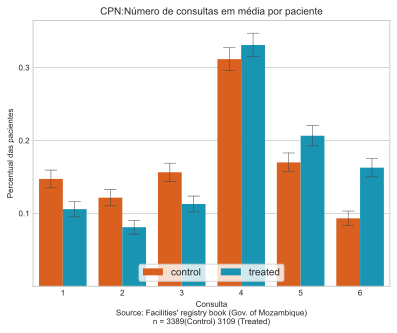

In [72]:
visits = (reg_book.groupby("treatment_status")["anc_total"]
     .value_counts(normalize=True)
     .rename('percent')
     .reset_index()
 .rename(columns={"index":"reason"})
 .set_index(["anc_total"])
 .sort_index())

def get_percent_visit(df):
    df = df.set_index(["treatment_status"])
    treated = df.loc["treated"]["percent"]
    control = df.loc["control"]["percent"]    
    return round(treated / control, 2)

title = "CPN:Número de consultas em média por paciente"

#plt.figure(figsize=(6, 3))
#plt.subplot(1, 2, 1)
g1 = plot_cathegorical(reg_book, "anc_total", title, order_=None,
                     normalize=True, figure=False, error=True)


plt.xlabel("Consulta" + "\n" + SOURCE_REG + "\n" + SIZE_REG_BOOK, size=8)
plt.yticks([0.1, 0.2, 0.3])
plt.ylabel("Percentual das pacientes", fontsize=8)

#ratio = (visits
#    .groupby(visits.index)
#    .apply(get_percent_visit)
#    .reset_index()
#    .rename(columns={0:"ratio",
#                     "anc_total":"visit"}))
#
#plt.subplot(1, 2, 2)
#ratio["visit"] = ratio["visit"].astype(int)
#sns.barplot(ratio, x="visit", y="ratio", color=TREATED)
#plt.ylim([0, 2])
#plt.xticks(range(0,7), fontsize=8)
#plt.yticks(fontsize=8)
#plt.axhline(1, color="black")
#plt.ylabel("")
#plt.xlabel("Visit", fontsize=8)
#plt.title("Ratio treatment/control per visit",fontsize=10)

#plt.figtext(0.35, -0.06, SOURCE_REG + "\n           " + SIZE_REG_BOOK,
#            fontsize=6, va='center')

img = f"{lse}/graphs"
plt.savefig(f"{img}/total_visits_per_patient.jpeg", bbox_inches='tight',dpi=300)

plt.show()

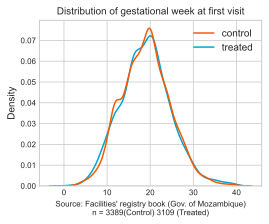

In [73]:
reg_book = reg_book[reg_book["gestational_age_1st"].notnull()]

title = "ANC: Gestational age at 1st appointment"
#plot_cathegorical(reg_book, "gestational_age_1st", title, y_size=3, 
#                  normalize=True)

plt.figure(figsize=(4, 3))
g=sns.kdeplot(reg_book, x="gestational_age_1st",
            hue="treatment_status", common_norm=False,
           palette=palette_anc, hue_order=order)

plt.title("Distribution of gestational week at first visit",
          fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(SOURCE_REG + "\n" + SIZE_REG_BOOK, size=8)
sns.move_legend(g, "upper right", ncol=1, title="")

plt.savefig(f"{img}/gestational_week.jpeg", bbox_inches='tight',dpi=300)


plt.show()

## Mechanisms

#### coefplot waiting_time

In [74]:
import forestplot as fp

import scipy.stats as st
def get_ci(n, mean, sem):
    return st.t.interval(alpha=0.95, df=n, loc=mean, scale=sem)#[1] - mean
def coef_plot(values, sem, n, title, xlabel, xticks=[0]):
    coef_wt = {}
    coef_wt["label"] = ["ITT-No Controls, No FE", "ITT-Only FE",
                        "ITT-Only Controls",
                        "ITT-Controls and FE",
                        "TOT-Controls and FE"]

    coef_wt["value"] = values

    coef_wt["lb"] = [get_ci(n, values[i], sem[i])[0] for i in range(5)]
    coef_wt["ub"] = [get_ci(n, values[i], sem[i])[1] for i in range(5)]

    coef_df = pd.DataFrame(coef_wt)


    ax = fp.forestplot(coef_df,  # the dataframe with results data
                  estimate="value",  # col containing estimated effect size 
                  ll="lb", hl="ub",  # lower & higher limits of conf. int.
                  varlabel="label",  # column containing the varlabels to be printed on far left
                  capitalize=None,  # Capitalize labels
                  ci_report=False,  # Turn off conf. int. reporting
                  flush=False,
                  #pval="pval",# Turn off left-flush of text
                  figsize=(3,2),
                  table=True,
                  xticks=xticks
                )
    plt.grid(False)
    plt.yticks(fontsize=8)
    plt.title(title,
              fontsize=10)
    plt.xlabel(xlabel,fontsize=8)
    return ax

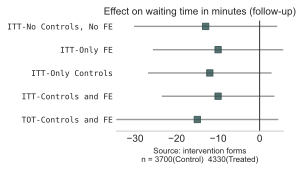

In [75]:
sem = [8.79, 8, 7.6, 6.92, 9.95]
values = [-13, -10, -12, -10, -15]
n=7600
title="Effect on waiting time in minutes (follow-up)"
xlabel=SOURCE_WT_FORMS + "\n" + SIZE_FOLLOWUP
coef_plot(values, sem, n, title, xlabel,xticks=[-30, -20, -10, 0])
plt.savefig(f"{img}/anc_effect_on_wt.jpeg", bbox_inches='tight',dpi=300)


plt.show()

#### arrival time

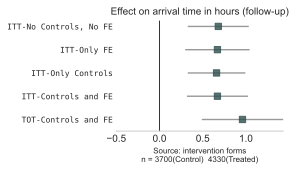

In [76]:
sem = [0.18, 0.19, 0.17, 0.18, 0.24]
values = [0.68, 0.67, 0.66, 0.67, 0.96]
n=8000
title="Effect on arrival time in hours (follow-up)"
xlabel=SOURCE_WT_FORMS + "\n" + SIZE_FOLLOWUP
coef_plot(values, sem, n, title, xlabel, xticks=[-0.5, 0,0.5,1])
plt.savefig(f"{img}/anc_arrival_time_effect.jpeg", bbox_inches='tight',dpi=300)

plt.show()

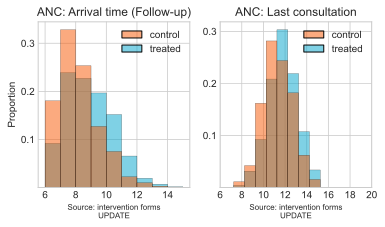

In [77]:

anc["arrival"] = anc["time_arrived"].apply(time_to_time_float)


plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)

g=sns.histplot( anc.query("consultation_reason == 2"),
             x="arrival", binwidth=1,
             hue="treatment_status", stat='proportion',
             common_norm=False, palette=palette_anc,
             hue_order=order)
sns.move_legend(g, "upper right", ncol=1, title="")
plt.xlabel(SOURCE_WT_FORMS + "\n" + "UPDATE", size=8)
plt.setp(g.patches, linewidth=0.2)
plt.xticks(range(6,16,2))
plt.yticks([.1, .2, .3])
plt.title("ANC: Arrival time (Follow-up)")

plt.subplot(1, 2, 2)

last_con = anc.groupby(["facility_cod", "day", "treatment_status"])["time_entered"].last().reset_index()
last_con["time_entered"] = last_con["time_entered"].apply(time_to_time_float)

g=sns.histplot( last_con,
             x="time_entered", binwidth=1,
             hue="treatment_status", stat='proportion',
             common_norm=False, palette=palette_anc,
             hue_order=order)
sns.move_legend(g, "upper right", ncol=1, title="")
plt.xlabel(SOURCE_WT_FORMS + "\n" + "UPDATE", size=8)
plt.setp(g.patches, linewidth=0.2)
plt.xticks(range(6,21,2))
plt.yticks([.1, .2, .3])
plt.title("ANC: Last consultation")
plt.ylabel("")


plt.savefig(f"{img}/anc_arrival_time_hist.jpeg", bbox_inches='tight',dpi=300)
plt.show()

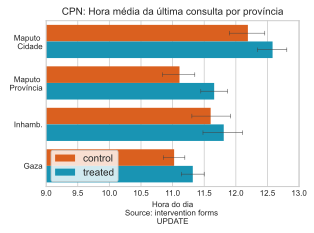

In [78]:
last_con = anc.groupby(["facility_cod", "day", "treatment_status", "province"])["time_entered"].last().reset_index()
last_con["time_entered"] = last_con["time_entered"].apply(time_to_time_float)


last_con["province_label"] = last_con["province"]
last_con["province_label"] = last_con["province_label"].replace({"Maputo Cidade":"Maputo \n Cidade",
                                                    "Maputo Província":"Maputo \n Província",
                                                    "Inhambane":"Inhamb."})

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)

province_order = ["Maputo \n Cidade", "Maputo \n Província",
                "Inhamb.", "Gaza"]

g = sns.barplot(last_con,
                x="time_entered", y="province_label",
                order=province_order,
                hue="treatment_status",palette=palette_anc,
                hue_order=order,errwidth=0.5, capsize=0.1,
                errorbar=("ci",95))
plt.xlabel("Hora do dia" + "\n" + SOURCE_WT_FORMS + " \n" + "UPDATE",
        size=8)

plt.ylabel("")
format_graph()
plt.title("CPN: Hora média da última consulta por província" ,fontsize=10)
sns.move_legend(g,loc='lower left', ncol=1, title="", frameon=True)
plt.xlim([9,13])
plt.savefig(f"{img}/anc_last_cons_province.jpeg", bbox_inches='tight',dpi=300)


#### share of patients before 10

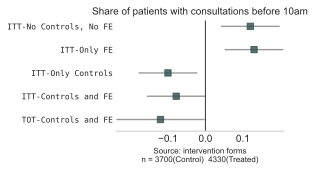

In [79]:
values = [0.12, 0.13, -0.10, -0.078, -0.12]
sem = [0.04, 0.04, 0.04, 0.04, 0.06]
n=800
title="Share of patients with consultations before 10am"
xlabel=SOURCE_WT_FORMS + "\n" + SIZE_FOLLOWUP
ax = coef_plot(values, sem, n, title, xlabel, xticks=[-0.1,0,0.1])

plt.savefig(f"{img}/anc_before_10.jpeg", bbox_inches='tight',dpi=300)

plt.show()


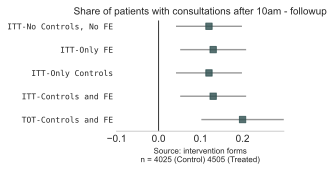

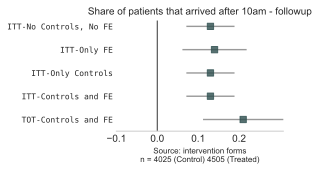

In [80]:
img = f"{lse}/graphs"

values = [.12, .13, .12, .13, .20]
sem = [0.04, 0.04, 0.04, 0.04, 0.05]
n=800
title="Share of patients with consultations after 10am - followup"
xlabel=SOURCE_WT_FORMS + "\n" + size_followup(anc)
ax = coef_plot(values, sem, n, title, xlabel, xticks=[-0.1,0,0.1,0.2])
plt.savefig(f"{img}/anc_consultation_after_10.jpeg", bbox_inches='tight',dpi=300)


values = [.13, .14, .13, .13, .21]
sem = [0.03, 0.04, 0.03, 0.03, 0.05]
n=800
title="Share of patients that arrived after 10am - followup"
xlabel=SOURCE_WT_FORMS + "\n" + size_followup(anc)
ax = coef_plot(values, sem, n, title, xlabel, xticks=[-0.1,0,0.1,0.2])
plt.savefig(f"{img}/anc_arrived_after_10.jpeg", bbox_inches='tight',dpi=300)



(5.0, 12.0)

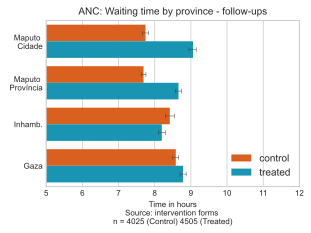

In [81]:
#anc
#


anc["province_label"] = anc["province"]
anc["province_label"] = anc["province_label"].replace({"Maputo Cidade":"Maputo \n Cidade",
                                                    "Maputo Província":"Maputo \n Província",
                                                    "Inhambane":"Inhamb."})

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)

province_order = ["Maputo \n Cidade", "Maputo \n Província",
                "Inhamb.", "Gaza"]

g = sns.barplot(anc.query("consultation_reason == 2"),
                x="time_arrived_float", y="province_label",
                order=province_order,
                hue="treatment_status",palette=palette_anc,
                hue_order=order,errwidth=0.5, capsize=0.1,
                errorbar=("ci",95))
plt.xlabel("Time in hours" + "\n" + SOURCE_WT_FORMS + " \n" + size_followup(anc),
        size=8)

plt.ylabel("")
format_graph()
plt.title("ANC: Waiting time by province - follow-ups" ,fontsize=10)
sns.move_legend(g,loc='lower right', ncol=1, title="", frameon=False)
plt.xlim([5,12])


## n de consultas por provincia

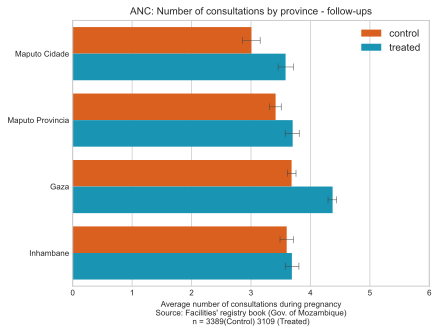

In [82]:
SIZE_REG_BOOK = "n = 3389(Control) 3109 (Treated)"

g = sns.barplot(reg_book,
                x="anc_total", y="province",
                hue="treatment_status",palette=palette_anc,
                hue_order=order,errwidth=0.5, capsize=0.1,
                errorbar=("ci",95))

plt.xlabel("Average number of consultations during pregnancy" + "\n" + SOURCE_REG + "\n" + SIZE_REG_BOOK,
        size=8)

plt.ylabel("")
format_graph()
plt.title("ANC: Number of consultations by province - follow-ups" ,fontsize=10)

sns.move_legend(g,loc='upper right', ncol=1, title="", frameon=False)
plt.xlim([0,6])

plt.savefig(f"{img}/regbook_total_visits_province.jpeg", bbox_inches='tight',dpi=300)


In [83]:
open_h_m = open_h.merge(facility_characteristics, 
                        left_on="facility_cod", right_on="facility_cod")

open_h_m.groupby(["province","treatment","complier"])["openting_time_hours"].mean()

NameError: name 'facility_characteristics' is not defined

### number of consultations coefplot

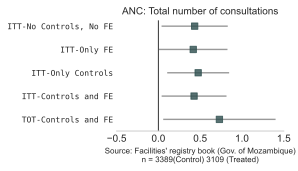

In [84]:
sem = [0.202, 0.209, 0.189, 0.198, 0.343]
values = [0.434, 0.417, 0.476, 0.427, 0.730]
n=6000
title="ANC: Total number of consultations" 
xlabel=SOURCE_REG + "\n" + SIZE_REG_BOOK
coef_plot(values, sem, n, title, xlabel, xticks=[-0.5, 0,0.5,1,1.5])

plt.savefig(f"{img}/consultations_per_patient.jpeg", bbox_inches='tight',dpi=300)

plt.show()

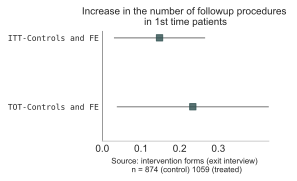

In [85]:
coef_wt = {}
coef_wt["label"] = ["ITT-Controls and FE",
                    "TOT-Controls and FE"]


sem = [0.06, 0.1]
values = [0.148, 0.234]
coef_wt["value"] = values
n=518

coef_wt["lb"] = [get_ci(n, values[i], sem[i])[0] for i in range(2)]
coef_wt["ub"] = [get_ci(n, values[i], sem[i])[1] for i in range(2)]

coef_df = pd.DataFrame(coef_wt)

ax = fp.forestplot(coef_df,  # the dataframe with results data
              estimate="value",  # col containing estimated effect size 
              ll="lb", hl="ub",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize=None,  # Capitalize labels
              ci_report=False,  # Turn off conf. int. reporting
              flush=False,
              #pval="pval",# Turn off left-flush of text
              figsize=(3,2),
              table=True,
              xticks=[0,0.1,0.2,0.3]
            )
SIZE_EXIT_INT = "n = 874 (control) 1059 (treated)"

plt.grid(False)
plt.yticks(fontsize=8)
plt.title("Increase in the number of followup procedures \n in 1st time patients ",
          fontsize=10)
xlabel = "Source: intervention forms (exit interview) \n " + SIZE_EXIT_INT
plt.xlabel(xlabel,fontsize=8)

plt.show()

#### procedures

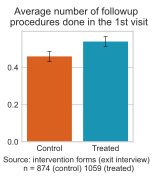

In [86]:
plt.figure(figsize=(2, 2))
sns.barplot(x=["Control","Treated"], y=[.46,.54],
            palette=palette_anc)

means = [.46, .54]
se = [0.027,0.027]
add_error_bar(means, se)

#plt.errorbar("1", 
#             .46,
#             yerr=0.027, 
#             color='black',
#             ecolor='black', elinewidth=.5, 
#             capsize=2, markeredgewidth=.5)
#plt.errorbar("2", 
#             .54,
#             yerr=0.027, 
#             color='black',
#             ecolor='black', elinewidth=.5,
#             capsize=2, markeredgewidth=.5)

sns.move_legend(g, "upper left", ncol=1, title="")
plt.xlabel(SOURCE_WT_FORMS)
plt.ylabel("Number of patients \n")
title="Average number of followup \n procedures done in the 1st visit"
plt.title(title, fontsize=10)
plt.ylabel("")
#plt.xlabel(SOURCE_REG, fontsize=8)
plt.xlabel(xlabel, fontsize=8)

format_graph()
#g.errorbar(x='reason', y='count', yerr='SD',
#           ls='', lw=3, color='black')

plt.show()

### REG BOOK: procedures

#### blood pressure

In [87]:
total = len(reg_book)
df = reg_book
for c in df.columns:
    df.loc[df[c] == "", c] = np.nan
for c in df.columns:
    not_null = len(df[df[c].notnull()])
    percent = not_null/total
    print(f"{c}:{round(percent,2)}")

province:1.0
district:1.0
facility_name:1.0
facility_cod:1.0
interview_supervisor_name:1.0
interview_date:0.92
room_type:0.98
room_cod:1.0
book_name:1.0
book_page:1.0
anc_total:1.0
date_1st_1:0.13
date_1st_2:0.1
date_2nd_2:0.1
date_1st_3:0.14
date_2nd_3:0.14
date_3rd_3:0.14
date_1st_4:0.32
date_2nd_4:0.32
date_3rd_4:0.32
date_4th_4:0.32
date_1st_5:0.19
date_2nd_5:0.19
date_3rd_5:0.19
date_4th_5:0.19
date_5th_5:0.19
date_1st_6:0.13
date_2nd_6:0.13
date_3rd_6:0.13
date_4th_6:0.13
date_5th_6:0.13
date_6th_6:0.13
patient_age_group:1.0
date_1st:0.99
date_last:0.82
gestational_age_1st:1.0
weight_1st:1.0
weight_2nd:1.0
weight_3rd:1.0
weight_4th:1.0
weight_5th:1.0
weight_6th:1.0
suplements_d:0.59
suplments_d:0.59
suplments_1st:0.59
suplments_2nd:0.59
suplments_3rd:0.59
suplments_4th:0.59
suplments_5th:0.59
suplments_6th:0.59
suplments_missing:0.59
ulcer_d:0.59
ulcer_1st:0.59
ulcer_2nd:0.59
ulcer_3rd:0.59
ulcer_4th:0.59
ulcer_5th:0.59
ulcer_6th:0.59
ulcer_missing:0.59
leucorrhoea_d:0.59
leucorr

In [88]:
#plt.figure(figsize=(6, 3))
#plt.subplot(1, 2, 1)
#
#
#title="ANC: Age group of patients with 4 visits or less"
#plot_cathegorical(reg_book_filtered.query("anc_total <= 4"),
#                  "patient_age_group", title, y_size=4,
#                     normalize=True, error=True, figure=False)
#
#n = len(reg_book_filtered)
#visit_by_age_text = f"\n n: {n} patients with more than 4 visits"
#plt.xlabel(SOURCE_REG + visit_by_age_text, size=8)
##sns.move_legend(g, "upper right", ncol=1, title="")
#
#
#
#plt.subplot(1, 2, 2)
#title="ANC: Age group of patients with more than 4 visits"
#plot_cathegorical(reg_book_filtered.query("anc_total > 4"),
#                  "patient_age_group", title, y_size=4,
#                     normalize=True, error=True, figure=False)
#
#n = len(reg_book_filtered.query("anc_total > 4"))
#visit_by_age_text = f"\n n: {n} patients with more than 4 visits"
#plt.xlabel(SOURCE_REG + visit_by_age_text, size=8)
#
#
#plt.savefig(f"{img}/regbook_visit_by_age.jpeg", bbox_inches='tight',dpi=300)
#
#plt.show()

## Procedures

In [110]:
def get_errors(df):
    mean = df.mean()
    p = mean
    se_95 = 1.96*np.sqrt(p*(1-p)/450)
    return (mean - se_95, mean + se_95)

procs = ["malaria_test",
"tetanus",
"blood_pressure",
"folic_acid",
"complications_sign",
"nutrition",
"delivery_place",
"malaria_pills",
"weight",
"examine_belly",
"uterine_height",
"delivery_plan",
"estimated",
"questions"]

procs_positive = ["malaria_test",
"tetanus",
"blood_pressure",
"folic_acid",
"complications_sign",
"nutrition",
"delivery_place"]

procs_same = ["malaria_pills",
"weight",
"examine_belly",
"uterine_height",
"delivery_plan",
"estimated",
"questions"]

exit_cleaned = pd.read_stata(f"{cleaned_path}/anc_exit_interview_cleaned.dta")
exit_cleaned["anc_total"] = pd.to_numeric(exit_cleaned["anc_total"],
                                          errors="coerce")
exit_cleaned = exit_cleaned.query("anc_total <= 12")

exit_cleaned = exit_cleaned.query("anc_total == 1")
procs_df = pd.DataFrame()
for var in procs:
    var_df = (exit_cleaned.groupby("treatment")
        [var].value_counts(normalize=True)
          .reset_index(name=f"{var}_")
          .sort_values(["treatment",f"{var}_"]) )
    var_df = var_df.query(f"{var}_ == 1")
    var_df[var] = f"{var}_"
    var_df = var_df.rename(columns={var:"proc"})
    procs_df = pd.concat([procs_df, var_df], axis=0)

CONTROL = "#F95700FF"#"#ffc387"
TREATED = "#00A4CCFF"#"#9ed9c3"
palette_anc = [CONTROL, TREATED]
order=["control","treated"]

procs_df["treatment_status"] = "treated"
procs_df.loc[procs_df["treatment"] == 0, "treatment_status"] = "control"

procs_df = procs_df.query(f"proc.isin({procs_positive})")

time_expected_category =  {
    "malaria_test":"Malaria Test",
    "tetanus":"Tetanus vaccine",
    "blood_pressure":"Blood Pressure",
    "folic_acid":"Folic acid",
    "complications_sign":"Checked for complication signs",
    "nutrition":"Nutrition advice",
    "delivery_place":"Indicated delivery place"
}
for k, v in time_expected_category.items():
    procs_df.loc[procs_df["proc"] == k, "proc"] = v

plt.figure(figsize=(4, 4))
graph = pd.concat([procs_df, procs_df.copy()], axis=0)
g = sns.barplot(graph, x="proportion", y="proc", hue="treatment_status",
           orient="h", errorbar=get_errors,
           errwidth=0.5, capsize=0.2,
           palette=palette_anc,
           hue_order=order)
sns.move_legend(g, "lower right", ncol=1, title="", frameon=True)
plt.ylabel("")
plt.title("Proportion of patients who received \n extra procedures on 1st visit")
plt.xlabel("Proportion \n Source: exit interview (n=1933)", fontsize=8)
plt.savefig(f"{img}/extra_proc_1st.jpeg", bbox_inches='tight',dpi=300)

plt.show()

ValueError: Could not interpret input 'proportion'

<Figure size 400x400 with 0 Axes>

# Heterogeneity

In [ ]:
For anc_readiness
    waiting_time
    number of consultations
    volume

infrastructure
baseline-volume

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

lse = "/Users/vincenzoalfano/LSE - Health/anc_hiv_scheduling"
img = f"{lse}/graphs"
cleaned_path = f"{lse}/data/cleaned_data"


In [112]:
def column_by_quantile(df, col, n_quantiles,n_round=2,format_int=True):
    """
        Divide the column in quantiles and generate a label
    """
    quantiles = np.linspace(0,1,n_quantiles+1)

    conditions = []
    labels = []
    for i,q in enumerate(quantiles[0:(n_quantiles)]):
        v = np.quantile(df[col], q)
        v_next = np.quantile(df[col], quantiles[i+1])
        
        # if last, changes comparison to lower or equal
        if i == n_quantiles-1:
            conditions.append( (df[col] >= v) & (df[col] <= v_next) )
        else:
            conditions.append( (df[col] >= v) & (df[col] < v_next) )
    
        if format_int:
            lower_bound = int(round(v,n_round))
            upper_bound = int(round(v_next,n_round))
        else:
            lower_bound = round(v,n_round)
            upper_bound = round(v_next,n_round)
            
        label = f"{lower_bound}-{upper_bound}"
        labels.append(label)
    
    return np.select(conditions, labels),labels

In [114]:
anc = pd.read_csv(f"{cleaned_path}/anc_cpn_endline_v20230704.csv")
facility_info = pd.read_stata(f"{lse}/data/aux/facility_characteristics.dta")
facility_info = facility_info.query("facility_cod != 36")


reg_book = reg_book.drop(["treatment","province"],axis=1)
reg_book = reg_book.merge(facility_info, left_on="facility_cod",
                right_on="facility_cod",how="inner")

#### waiting time x urban

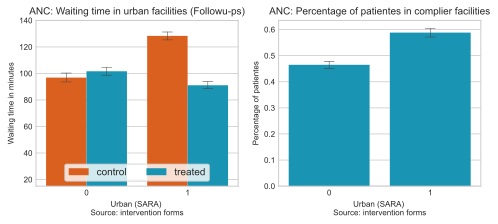

In [116]:
followup = anc.query("consultation_reason == 2")

#followup.groupby(["urban","treatment"])["waiting_time"].mean()

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
g = sns.barplot(followup, x="urban",
            y="waiting_time",
            hue="treatment_status",
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("ANC: Waiting time in urban facilities (Followu-ps)" ,fontsize=10)

plt.xlabel("Urban (SARA) \n" + SOURCE_WT_FORMS, size=8)
sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)
plt.ylabel("Waiting time in minutes", fontsize=8)
plt.ylim([15,140])
format_graph()

plt.subplot(1, 2, 2)
g = sns.barplot(followup, x="complier",
            y="urban", color=TREATED,
            errwidth=0.5, capsize=0.1)
plt.title("ANC: Percentage of patientes in complier facilities" ,fontsize=10)

plt.xlabel("Urban (SARA) \n" + SOURCE_WT_FORMS, size=8)

#sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)
plt.ylabel("Percentage of patientes", fontsize=8)
format_graph()

plt.show()

#### waiting_time x baseline_volume

In [117]:
followup["base_vol"].value_counts()

KeyError: 'base_vol'

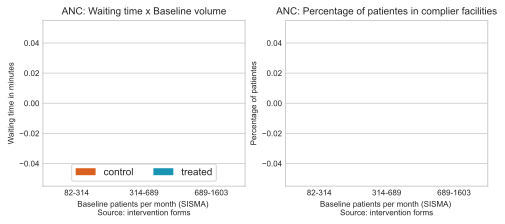

In [118]:
followup = anc.query("consultation_reason == 2")

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

base_vol,labels_base_vol = column_by_quantile(followup, "volume_base_total", 3,
                                            n_round=0,format_int=False)
followup["base_vol"] = base_vol
followup["base_vol"] = followup["base_vol"].str.replace(".0","")

order_base_bol=["82-314", "314-689", "689-1603"]
g = sns.barplot(followup, x="base_vol",
            y="waiting_time",
            hue="treatment_status",
            order=order_base_bol,
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
plt.xlabel("Baseline patients per month (SISMA) \n" + SOURCE_WT_FORMS, size=8)
plt.ylabel("Waiting time in minutes", fontsize=8)
plt.title("ANC: Waiting time x Baseline volume" ,fontsize=10)
format_graph()
sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)

plt.subplot(1, 2, 2)
g = sns.barplot(followup, x="base_vol",
            y="complier", color=TREATED,
            order=order_base_bol,
            errwidth=0.5, capsize=0.1)
plt.title("ANC: Percentage of patientes in complier facilities" ,fontsize=10)

plt.xlabel("Baseline patients per month (SISMA) \n" + SOURCE_WT_FORMS, size=8)

#sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)
plt.ylabel("Percentage of patientes", fontsize=8)
format_graph()

#plt.savefig(f"{img}/anc_het_wt_vol.jpeg", bbox_inches='tight',dpi=300)

In [119]:
plt.figure(figsize=(4, 3))
g = sns.barplot(data=followup, x="reason", y="count",
            hue="treatment_status", palette=palette_anc,
            hue_order=order)
sns.move_legend(g, "upper left", ncol=1, title="")
plt.xlabel(SOURCE_WT_FORMS)
plt.ylabel("Number of patients \n")
title="ANC: average number of patients per day"
plt.title(title)

ValueError: Could not interpret input 'count'

<Figure size 400x300 with 0 Axes>

#### waiting_time

In [120]:
column_by_quantile(anc, "index_ANC_readiness", 3,
                n_round=2,format_int=False)

KeyError: 'index_ANC_readiness'

In [ ]:
anc["time_arrived"].div(100).apply(lambda x: x <= 10)

In [ ]:
anc["arrived_before_10"] = anc["time_arrived"].div(10)

anc.groupby("treatment")["time_arrived_float"].mean()

In [ ]:
readiness,labels_readiness = column_by_quantile(anc, "index_ANC_readiness", 3,
                                n_round=2,format_int=False)
anc["readiness"] = readiness
anc["readiness"] = anc["readiness"].replace('0.1-0.6',"Low")
anc["readiness"] = anc["readiness"].replace('0.6-0.8',"Medium")
anc["readiness"] = anc["readiness"].replace('0.8-1.0',"High")
g = sns.barplot(anc, x="readiness", 
            y="waiting_time", 
            hue="treatment_status",
            order=["Low", "Medium", "High"], 
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)

plt.xlabel("Índice de preparo para ANC (SARA) \n" + SOURCE_WT_FORMS, size=8)
plt.xlabel("ANC readiness (SARA) \n" + SOURCE_WT_FORMS, size=8)

plt.ylabel("Tempo de espera em minutos", fontsize=8)
plt.ylabel("Waiting time in minutes", fontsize=8)
format_graph()
plt.title("CPN: Média de tempo de espera x preparação da US" ,fontsize=10)
plt.title("ANC: Waiting time x Facility readiness" ,fontsize=10)

sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)

#plt.savefig(f"{img}/het_wt_read.jpeg", bbox_inches='tight',dpi=300)

plt.show()

#### number of consultations

In [ ]:
readiness,labels_readiness = column_by_quantile(reg_book, "index_ANC_readiness", 3,
                n_round=2,format_int=False)
reg_book["readiness"] = readiness
reg_book["readiness"] = reg_book["readiness"].replace('0.1-0.6',"Low")
reg_book["readiness"] = reg_book["readiness"].replace('0.6-0.8',"Medium")
reg_book["readiness"] = reg_book["readiness"].replace('0.8-1.0',"High")

g = sns.barplot(reg_book, x="readiness", 
            y="anc_total", 
            hue="treatment_status",
            order=["Low", "Medium", "High"],
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)

plt.xlabel("Índice de preparo para ANC (SARA) \n" + SOURCE_REG, size=8)
plt.xlabel("ANC readiness (SARA) \n" + SOURCE_REG, size=8)

plt.ylabel("Média de consultas na gestação", fontsize=8)
plt.ylabel("Total consultations during pregnancy", fontsize=8)
format_graph()
plt.title("CPN: Média de consultas x preparação da US" ,fontsize=10)
plt.title("ANC: Number of consultations x Facility readiness" ,fontsize=10)

sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)

plt.savefig(f"{img}/het_anc_total_read.jpeg", bbox_inches='tight',dpi=300)

plt.show()

### visits by age

In [ ]:
reg_book_filtered = (reg_book
    .query("patient_age_group != 'S/I' & patient_age_group != '10 - 14 anos'"))

reg_book_filtered.loc[:,"patient_age_group"] = (reg_book_filtered["patient_age_group"]
                                                .str.replace(" anos",""))
order_age = ["15 - 19","20 - 24","≥ 25"]
g = sns.barplot(reg_book_filtered,
            x="patient_age_group", y="anc_total",
            hue="treatment_status",palette=palette_anc,
            order=order_age,
            hue_order=order,errwidth=0.5, capsize=0.1)
sns.move_legend(g, "upper right", ncol=1, title="")
#plt.title("ANC: Arrival time (Follow-up consultations)")
plt.xlabel("Livros de registro \n" + SIZE_REG_BOOK, size=8)
plt.xlabel(SOURCE_REG, size=8)

plt.ylabel("")
format_graph()
plt.title("CPN: Média de consultas por faixa etária" ,fontsize=10)
plt.title("ANC: Total consultations by age group" ,fontsize=10)

sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)

plt.savefig(f"{img}/regbook_visit_by_age.jpeg", bbox_inches='tight',dpi=300)

plt.show()

#### Volume

In [121]:
** relacao entre a adesao ao tratamento e o volume pre tratamento
** relacao entre a adesao ao tratamento e o volume pos tratamento

SyntaxError: invalid syntax (3917479114.py, line 1)

In [ ]:
sns.barplot(reg_book, x="province", 
            y="anc_total", 
            hue="treatment",
            order=readiness_order)
plt.show()

#### HIV: share before 10

In [55]:
hiv["share_10"] = 0
hiv.loc[hiv["arrival_time"] < 1000, "share_10"] = 1
hiv.groupby("treatment").agg({"share_10":["mean","sem"]})

share_10          
              mean       sem
treatment                   
0          0.64223  0.004632
1          0.62774  0.004396

In [57]:
facility_characteristics = pd.read_stata(f"{aux}/facility_characteristics.dta")
volume_baseline = pd.read_stata(f"{aux}/facility_volume_baseline.dta")


In [58]:
def size_1st(anc):
    len_c = len(anc.query("consultation_reason == 1 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 1 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

def size_followup(anc):
    len_c = len(anc.query("consultation_reason == 2 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 2 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

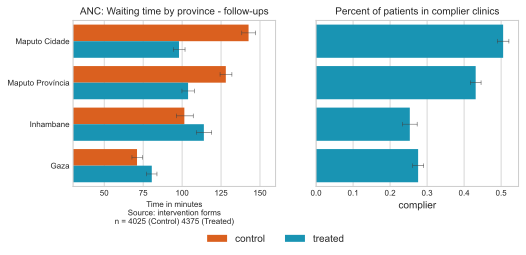

In [59]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

province_order = ["Maputo Cidade", "Maputo Província",
                  "Inhambane", "Gaza"]

g = sns.barplot(anc.query("consultation_reason == 2"),
                x="waiting_time", y="province",
                order=province_order,
                hue="treatment_status",palette=palette_anc,
                hue_order=order,errwidth=0.5, capsize=0.1,
                errorbar=("ci",95))
plt.xlabel("Time in minutes" + "\n" + SOURCE_WT_FORMS + "\n" + size_followup(anc),
           size=8)

plt.ylabel("")
format_graph()
plt.title("ANC: Waiting time by province - follow-ups" ,fontsize=10)
plt.xlim([30,160])

#sns.move_legend(g, "lower right", ncol=2, title="", frameon=True)
sns.move_legend(g,loc='lower center', ncol=2, title="", frameon=False,
               bbox_to_anchor=(1, -.4))

plt.subplot(1, 2, 2)
sns.barplot(anc,
                x="complier", y="province",
                order=province_order,errwidth=0.5, capsize=0.1,
                errorbar=("ci",95), color=TREATED)
plt.title("Percent of patients in complier clinics",size=10)
plt.yticks([])
plt.ylabel("")
format_graph()

#plt.show()
plt.savefig(f"{img}/anc_wt_province.jpeg", bbox_inches='tight',dpi=300)